# IT8 Negative ( >10 words) & ( >1.0 thumbsup)

Coding was developed based on below sources:
* Brandonrose.org. (2018). Document Clustering with Python. [online] Available at: http://brandonrose.org/clustering 
* Scikit-learn.org. (2018). sklearn.metrics.silhouette_score — scikit-learn 0.19.2 documentation. [online] Available at: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
* Twitterdev.github.io. (2018). Do More with Twitter Data — Do more with Twitter data 0.1 documentation. [online] Available at: https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpld3
import sys
import csv
import string
from time import time

In [103]:
dsa_data = pd.read_csv('/Users/jessicakuo/Documents/Data/depression-stress-anxiety.csv')
dsa_data = dsa_data.dropna() #filter out empty rows; otherwise it will fail later
dsa_data.columns = ['appname', 'rating', 'ratingcount', 'developer','apptype','reviewer','date','reviewer_rating','thumbsup','review']
dsa_data['words'] = dsa_data['review'].str.split()
dsa_data['word_len'] = dsa_data['words'].str.len()
print('Total reviews: ',len(dsa_data))

#filter in only if >1 people gave thumbs-up & >10 words
print('>1 people gave thumbs-up')
dsa_negative = dsa_data[(dsa_data.reviewer_rating<3) & (dsa_data.thumbsup>1.0) &(dsa_data.word_len>13)]
print('Total number of negative reviews users vote useful: ', len(dsa_negative))
print()
#dsa_negative.head()

Total reviews:  63474
>1 people gave thumbs-up
Total number of negative reviews users vote useful:  1291



In [4]:
#examine the data

dsa_negative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1291 entries, 68 to 63516
Data columns (total 12 columns):
appname            1291 non-null object
rating             1291 non-null float64
ratingcount        1291 non-null object
developer          1291 non-null object
apptype            1291 non-null object
reviewer           1291 non-null object
date               1291 non-null object
reviewer_rating    1291 non-null float64
thumbsup           1291 non-null float64
review             1291 non-null object
words              1291 non-null object
word_len           1291 non-null int64
dtypes: float64(3), int64(1), object(8)
memory usage: 131.1+ KB


In [98]:
#create lists of filtered reviews
neg_apps = dsa_negative['appname'].tolist()
neg_reviews = dsa_negative['review'].tolist()
ratings = dsa_negative['reviewer_rating'].tolist()
thumbsup = dsa_negative['thumbsup'].tolist()

# Data Cleaning

In [6]:
# load NLTK's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['review','text','app',"also","would","stress","anxiety","depression","saying"]
stopwords.extend(newStopWords)
print (stopwords[:-1])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
# load NLTK's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stopwords]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [9]:
# use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in neg_reviews:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'review_texts', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

print("Number of vocab tokenized and stemmed: ", len(totalvocab_stemmed))
print("Number of vocab tokenized only: ",len(totalvocab_tokenized))

Number of vocab tokenized and stemmed:  25444
Number of vocab tokenized only:  25444


In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 25444 items in vocab_frame


In [11]:
print (vocab_frame.head())

        words
alarm  alarms
work     work
miss   missed
least   least
far       far


In [12]:
# Count frequency of words
from collections import Counter
list1=totalvocab_stemmed
counts = Counter(list1)
print(counts)

Counter({'use': 305, 'get': 287, 'like': 265, 'time': 262, 'help': 252, 'work': 238, 'tri': 233, 'even': 203, 'one': 199, 'peopl': 179, 'pay': 179, 'listen': 173, 'need': 171, 'free': 169, 'realli': 164, 'day': 159, 'make': 156, 'medit': 150, 'want': 148, 'month': 133, 'therapist': 131, 'money': 125, 'good': 120, 'give': 119, 'great': 114, 'could': 106, 'subscript': 105, 'uninstal': 105, 'much': 104, 'first': 102, 'ask': 101, 'talk': 100, 'back': 100, 'someon': 97, 'seem': 93, 'know': 93, 'thing': 92, 'way': 92, 'see': 90, 'say': 90, 'servic': 89, 'feel': 88, 'love': 88, 'pleas': 87, 'think': 84, 'screen': 83, 'start': 82, 'keep': 81, 'updat': 80, 'ad': 80, 'stop': 80, 'rate': 79, 'got': 79, 'fix': 78, 'phone': 78, 'never': 77, 'noth': 77, 'take': 76, 'look': 75, 'better': 75, 'everi': 74, 'paid': 73, 'read': 72, 'person': 71, 'still': 69, 'account': 68, 'charg': 67, 'tell': 67, 'support': 66, 'download': 65, 'issu': 65, 'actual': 65, 'mani': 65, 'open': 65, 'without': 65, 'abl': 64, '

# Tfidf Vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.01, stop_words=stopwords,
                                   use_idf=True,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(neg_reviews) #fit the vectorizer to review_texts

print(tfidf_matrix.shape)

CPU times: user 1.31 s, sys: 12.7 ms, total: 1.32 s
Wall time: 1.39 s
(1291, 418)


In [14]:
# Etermining what terms are useful enough to turn into features
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))
terms

418


['abl',
 'absolut',
 'access',
 'account',
 'activ',
 'actual',
 'ad',
 'add',
 'address',
 'advertis',
 'advic',
 'afford',
 'allow',
 'almost',
 'alreadi',
 'alway',
 'amount',
 'android',
 'annoy',
 'anoth',
 'answer',
 'anymor',
 'anyon',
 'anyth',
 'around',
 'ask',
 'audio',
 'avail',
 'aw',
 'away',
 'back',
 'bad',
 'balloon',
 'basic',
 'becom',
 'begin',
 'best',
 'better',
 'big',
 'bit',
 'bother',
 'breath',
 'bug',
 'button',
 'buy',
 'call',
 'came',
 'cancel',
 'cant',
 'card',
 'care',
 'caus',
 'chang',
 'charg',
 'chat',
 'check',
 'claim',
 'clear',
 'click',
 'close',
 'color',
 'come',
 'comment',
 'communiti',
 'complet',
 'concept',
 'connect',
 'constant',
 'contact',
 'content',
 'continu',
 'convers',
 'cool',
 'cost',
 'could',
 'crash',
 'creat',
 'custom',
 'daili',
 'data',
 'day',
 'deal',
 'delet',
 'depress',
 'design',
 'develop',
 'differ',
 'difficult',
 'disappoint',
 'dollar',
 'done',
 'dont',
 'download',
 'due',
 'easi',
 'either',
 'els',
 'em

In [15]:
# dist is defined as 1 - the cosine similarity of each document. 
# Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity 
# between each document and the other documents in the corpus (each review among the reviews). 
# Subtracting it from 1 provides cosine distance which is used for plotting on a euclidean (2-dimensional) plane.
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 21.4 ms, sys: 13.6 ms, total: 35 ms
Wall time: 33.1 ms


# K-means clustering

In [16]:
import pandas
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Elbow Curve - Finding the best parameter 

CPU times: user 3.83 s, sys: 1.99 s, total: 5.81 s
Wall time: 38.1 s


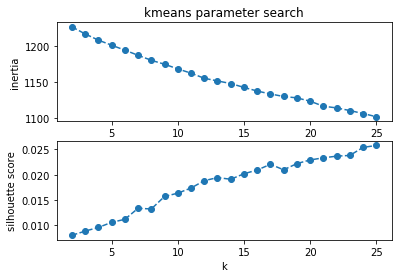

In [89]:
%%time

import logging
#from sklearn.metrics import silhouette_score
seed = 42

# compare a broad range of ks to start
ks = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed)
    model.fit(tfidf_matrix)
    labels = model.labels_
    sil_scores.append(silhouette_score(tfidf_matrix, labels))
    inertias.append(model.inertia_)

# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [18]:
#from sklearn.metrics import silhouette_samples, silhouette_score

X = tfidf_matrix

range_n_clusters = [2, 3, 4, 5, 6 , 7, 8, 9 ,10]
seed = 1
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value
    # seed of 1 for reproducibility
    km = KMeans(n_clusters=n_clusters, random_state=seed).fit(tfidf_matrix)
    labels = km.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.008254097181032177
For n_clusters = 3 The average silhouette_score is : 0.008944230183896212
For n_clusters = 4 The average silhouette_score is : 0.00980817995086396
For n_clusters = 5 The average silhouette_score is : 0.011499399726695158
For n_clusters = 6 The average silhouette_score is : 0.011762064553054287
For n_clusters = 7 The average silhouette_score is : 0.013267835800384733
For n_clusters = 8 The average silhouette_score is : 0.015257275964359744
For n_clusters = 9 The average silhouette_score is : 0.014958351875733668
For n_clusters = 10 The average silhouette_score is : 0.01666755804538746


## (7 clusters) 

In [20]:
# Do KMeans clustering to get the clusters
#from sklearn.cluster import KMeans

num_clusters = 7
seed = 1

km = KMeans(n_clusters=num_clusters, random_state=seed)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 1.61 s, sys: 8.37 ms, total: 1.62 s
Wall time: 1.64 s


In [21]:
# Use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle
joblib.dump(km,  'doc_cluster8-1.pkl')

km = joblib.load('doc_cluster8-1.pkl')
clusters = km.labels_.tolist()

In [22]:
# Create dictionary
appreview = { 'review': neg_reviews, 'cluster': clusters}
frame = pd.DataFrame(appreview, index = [clusters] , columns = ['review','cluster'])

In [23]:
frame.to_csv("IT8-1Sample.csv")

In [99]:
# Create dictionary
appreview2 = { 'review': neg_reviews, 'cluster': clusters, 'review_rating': ratings, 'thumbsup': thumbsup}
frame2 = pd.DataFrame(appreview2, index = [clusters] , columns = ['review','cluster','review_rating','thumbsup'])

In [100]:
frame2.to_csv("IT8-1Frame2.csv")

In [24]:
#number of reviews per cluster (clusters from 0 to 4)
frame['cluster'].value_counts()

4    526
1    194
2    165
6    152
3    104
0     91
5     59
Name: cluster, dtype: int64

In [25]:
# indexing and sorting on each cluster to identify which are the top n (I used n=50) words that are nearest 
# to the cluster centroid. This gives a good sense of the main topic of the cluster.
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :50]: #replace with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        
    print() #add whitespace
    print() #add whitespace

print()

Top terms per cluster:

Cluster 0 words: account, therapist, creating, tried, day, even, email, getting, needs, time, message, require, got, give, responded, nothing, log, took, anything, sign, could, week, like, money, deleting, wasted, services, make, change, response, data, without, find, telling, let, therapy, wanted, one, support, allowed, facebook, charged, helpful, complete, two, right, write, new, says, severe,

Cluster 1 words: work, open, tried, crashes, love, fix, load, update, nothing, time, use, keeps, started, screening, sessions, meditation, great, even, uninstalled, getting, really, stopped, prayer, play, restarts, phone, please, like, first, happens, still, game, reinstalling, downloaded, internet, stuck, installed, could, sounded, page, bug, frustrating, every, looks, well, good, issues, message, move, make,

Cluster 2 words: free, paying, month, subscription, use, day, trial, charged, getting, like, one, great, much, pricing, meditation, fee

/Users/jessicakuo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


, money, year, buy, wanted, better, premium, per, worth, make, services, tried, time, first, costs, could, card, payment, paid, work, see, expensive, week, really, refundable, content, features, happy, without, love, way, canceled, needs, version, good,

Cluster 3 words: listeners, talk, someone, tried, people, helpful, wanted, could, feelings, time, one, stopped, find, needs, reply, getting, asks, like, connect, got, conversation, even, advice, great, give, problems, use, personal, leave, chats, paying, uninstalled, less, badly, therapist, minutes, please, first, thing, says, idea, speak, make, knowing, issues, message, downloaded, rude, hope, voice,

Cluster 4 words: use, getting, like, meditation, time, even, one, read, rated, make, way, phone, questions, knowing, needs, good, uninstalled, heart, voice, back, able, says, give, wanted, sounded, much, email, tried, really, sign, never, asks, day, play, downloaded, thing, screening, telling, update, keeps, looks, options, take, install

# Multidimensional scaling

In [27]:
# convert the dist matrix into a 2-dimensional array using multidimensional scaling (MDS)
import os  # for os.path.basename

#import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()

CPU times: user 29.3 s, sys: 8.77 s, total: 38.1 s
Wall time: 36.6 s



In [28]:
#save nparray
#import numpy as np
a = pos
np.savetxt("IT8-1POSnparray.csv", a, delimiter=",")

# Visualizing document clusters

In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#5B1B9E', 6: '#9E1B7E', 7: '#9E1B22', 8: '#969E1B', 9: '#D3F22F',
                  10: '#F2602F', 11: '#50C7F4', 12: '#8ECE92', 13: '#E79FC0', 14: '#74045E',
                  15: '#EC86DD', 16: '#508DF4', 17: '#F4EB10', 18: '#C94E86', 19: '#5C45A5',
                  20: '#F0D0EB', 21: '#109C19', 22: '#E7E59F', 23: '#740437', 24: '#1AAEC3'}

#set up cluster names using a dict
cluster_names = {0: 'cluster1', 
                 1: 'cluster2', 
                 2: 'cluster3',
                 3: 'cluster4',
                 4: 'cluster5', 
                 5: 'cluster6', 
                 6: 'cluster7'}

### First, define some dictionaries for going from cluster number to color and to cluster name. Then, based the cluster names off the words that were closest to each cluster centroid.

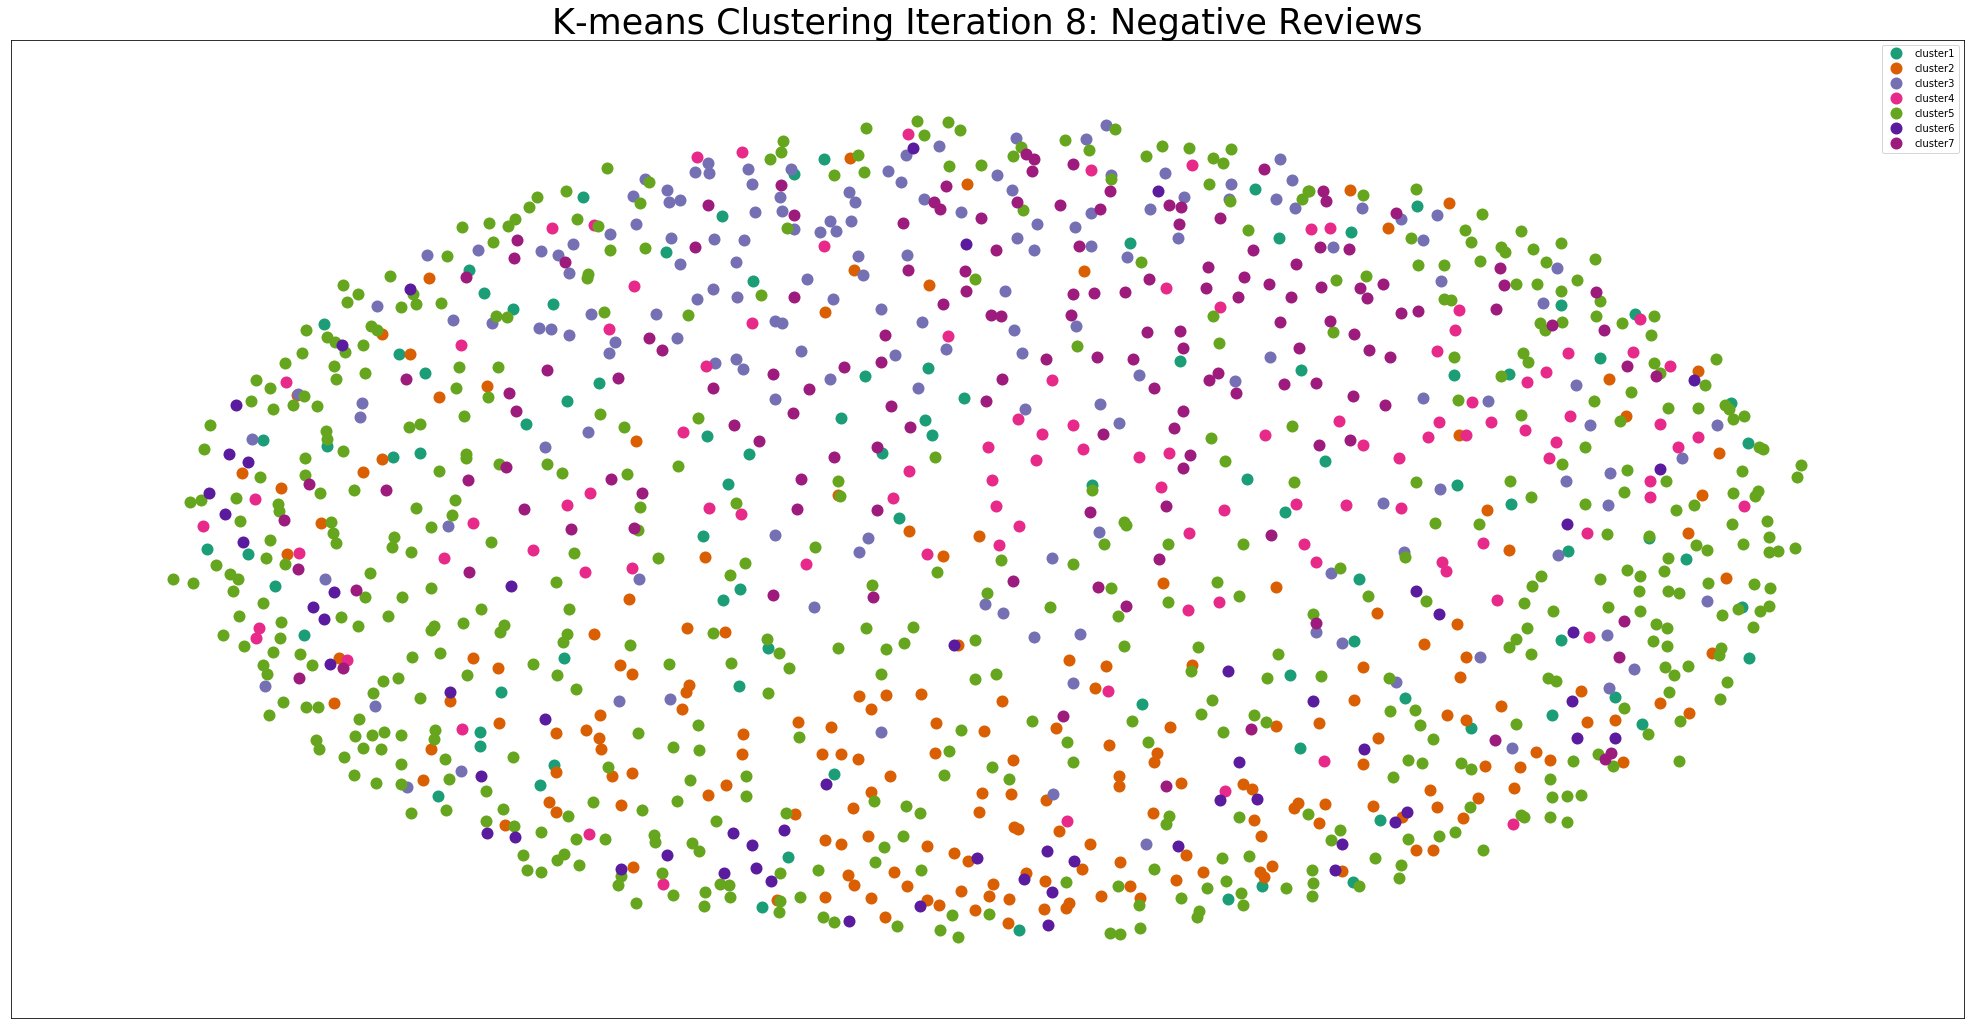

In [88]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, review=neg_reviews)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(35, 18)) # set size
ax.margins(0.1) # Add padding

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point
plt.title('K-means Clustering Iteration 8: Negative Reviews', size = 35)

plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters.png', dpi=200)

In [ ]:
plt.close()

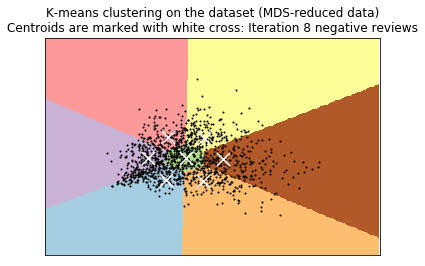

In [90]:
# Visualize the results on MDS-reduced data
km.fit(pos)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = km.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = km.labels_

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the dataset (MDS-reduced data)\n'
          'Centroids are marked with white cross: Iteration 8 negative reviews')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

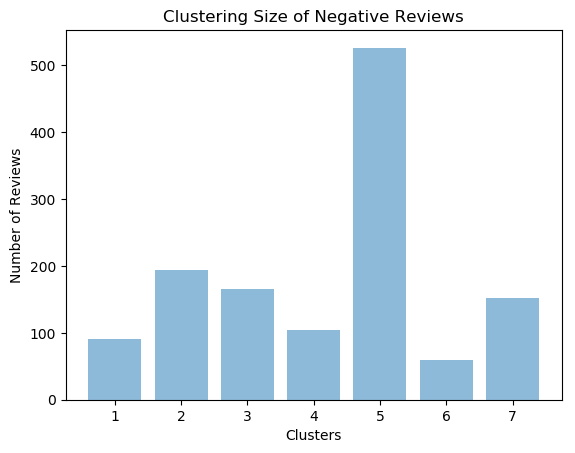

In [92]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
cluster_name = [1,2,3,4,5,6,7]
y_pos = np.arange(len(cluster_name))
performance = [91, 194, 165, 104, 526,  59, 152]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, cluster_name)
plt.ylabel('Number of Reviews')
plt.xlabel('Clusters')
plt.title('Clustering Size of Negative Reviews')

percent_of_goal = ["{}%".format(int(100.*row.sales/row.goal)) for name,row in car_sales_sorted.iterrows()]
 for i,child in enumerate(ax.get_children()[:car_sales_sorted.index.size]):
 ax.text(child.get_bbox().x1+200,i,percent_of_goal[i], verticalalignment ='center')

# Text on the top of each barplot
for i in range(len(r4)):
plt.text(x = r4[i]-0.5 , y = bars4[i]+0.1, s = label[i], size = 6)
 
plt.show()

For n_clusters = 7 The average silhouette_score is : 0.013267835800384733


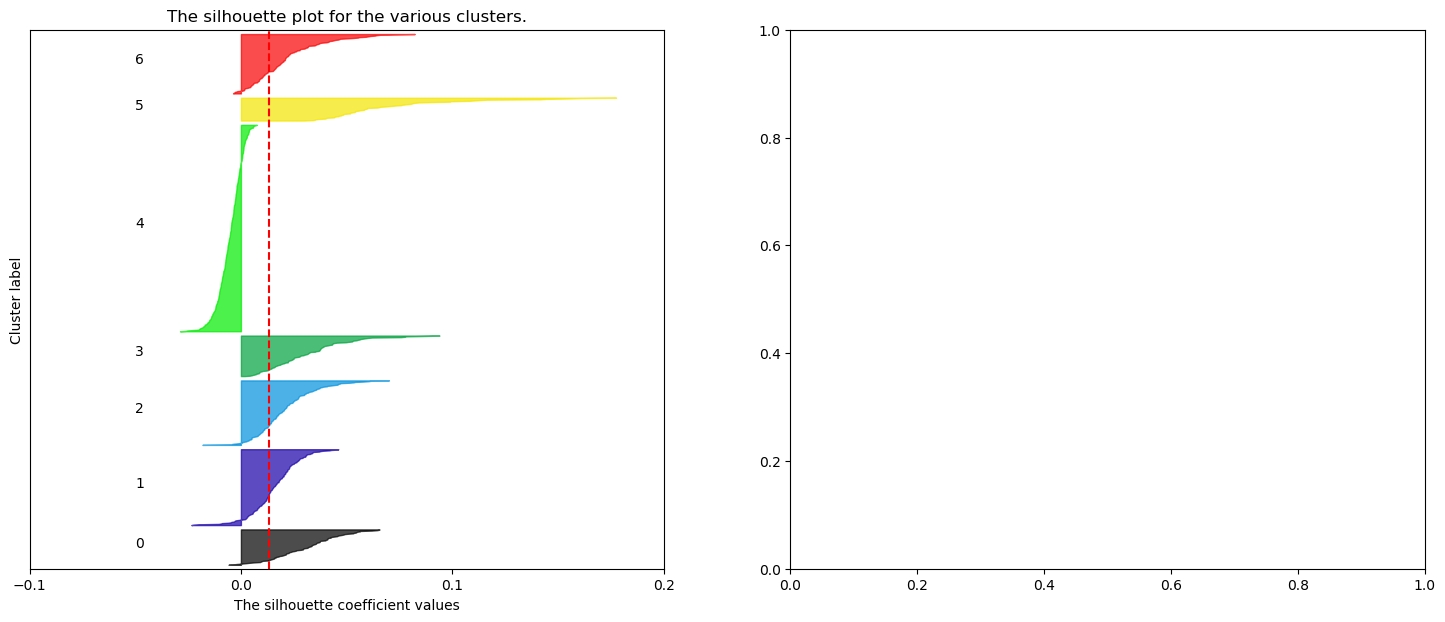

In [96]:
X = tfidf_matrix 
range_n_clusters = [7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1=0.2]
    ax1.set_xlim([-0.1, 0.2])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 1 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1).fit(X)
    cluster_labels = clusterer.fit_predict(X)  
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.1, 0.2])